In [7]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

This example is intended to show how to use a class in a way that's more relevant to AREN 

In [8]:
def f2c(temp_f):
    temp_c = (temp_f - 32) * 5 / 9
    return temp_c
    
def c2f(temp_c):
    temp_f = (temp_c - 32) * 9 / 5
    return temp_f

This object represents an HVAC system. It should be used in conjunction with a house model, but if you want to compare multiple hvac installations in the same house it might be useful to organize HVAC as a seperate class from House

In [9]:
class HVAC:
    def __init__(self, p_cooling, p_heating, seer, hspf):
        self.pc = p_cooling
        self.ph = p_heating
        self.seer = seer
        self.hspf = hspf

Here's a house object that will update the temperature inside the hosue.

In [79]:
class House:
    def __init__(self, hvac, wall_r, wall_c, init_temp=22, dt=1):
        self.hvac = hvac
        self.r = wall_r
        self.c = wall_c
        self.temp = init_temp
        self.dt = dt
        self.time = 0
        
    def get_current_oat(self, time):
        return 30 + np.sin(2 * np.pi * time / (24 * self.dt))
        
    def update(self, action):
        """
        Let the input 'action' be +1 for heating, 0 for nothing, 
        or -1 for cooling.
        """
        self.time += 1
        oat_current = self.get_current_oat(self.time)
        p_hvac = 1000 * (np.clip(action, 0, None) * self.hvac.ph + np.clip(action, None, 0) * self.hvac.pc)
        self.temp += (((oat_current - self.temp) / self.r) + p_hvac / 3600) / self.c * self.dt
        return self.temp
    
    def optimize(self, nhours):
        """
        Here the house will determine the 
        optimal actions over the next n hours.
        """
        
        s_heat = cp.Variable(nhours)
        s_cool = cp.Variable(nhours)
        p_hvac = cp.Variable(nhours)
        p_cons = cp.Variable(nhours)
        temp = cp.Variable(nhours+1)
        tmin = 20
        tmax = 25
        
        obj = cp.Minimize(cp.sum(p_cons))
        
        oat = [self.get_current_oat(t) for t in range(self.time, self.time+nhours)]
        cons = [
            temp[0] == self.temp,
            temp[1:] == self.temp + (((oat - temp[:-1]) / self.r + (p_hvac / 3600))) / self.c * self.dt,
            p_hvac == 1000 * (s_heat * self.hvac.ph - s_cool * self.hvac.pc),
            p_cons == s_heat / self.hvac.hspf * self.hvac.ph - self.hvac.seer * s_cool * self.hvac.pc,
            temp[1:] >= tmin,
            temp[1:] <= tmax,
            s_cool <= 1,
            s_cool >= 0,
            s_heat <= 1,
            s_heat >= 0
            # there's something missing here. what is it?
        ]
        prob = cp.Problem(obj, cons)
        prob.solve(verbose=False)
        return temp.value, s_heat.value, s_cool.value

In [80]:
ashp = HVAC(7, 26, 14, 8.2) # an airsource heatpump
myhome = House(ashp, 7.5, 5)

In [64]:
t_in = []
actions = [] 
for _ in range(5):
    action = np.random.randint(-1,1)
    t_in += [myhome.update(action)]
    actions += [action]

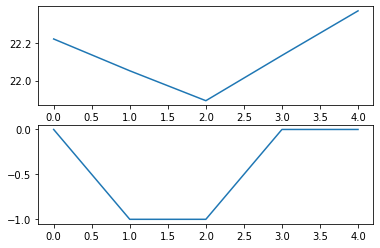

In [65]:
fig, ax = plt.subplots(2)
ax[0].plot(t_in)
ax[1].plot(actions)

In [81]:
myhome.optimize(24)

(array([22.        , 21.82444445, 21.83602778, 21.84215038, 21.84750996,
        21.85160487, 21.85415968, 21.8550002 , 21.85406914, 21.85142995,
        21.8472625 , 21.84185079, 21.83556361, 21.82882942, 21.82210716,
        21.81585493, 21.81049881, 21.80640381, 21.803849  , 21.80300848,
        21.80393954, 21.80657872, 21.81074617, 21.81615789, 21.82244507]),
 array([5.62960824e-09, 5.91849702e-09, 5.92456205e-09, 5.93552874e-09,
        5.94365832e-09, 5.94870363e-09, 5.95041270e-09, 5.94870425e-09,
        5.94365949e-09, 5.93552599e-09, 5.92472623e-09, 5.91186375e-09,
        5.89771735e-09, 5.88321434e-09, 5.86937753e-09, 5.85724674e-09,
        5.84778213e-09, 5.84176288e-09, 5.83969774e-09, 5.84176338e-09,
        5.84778848e-09, 5.85704166e-09, 5.87746749e-09, 5.56622539e-09]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.]))